<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>

Привет Кирилл! Меня зовут Марат, и я буду твоим ревьюером. Спешу сообщить что все ключевые этапы в работе выполнены,  с задачей тебе удалось справиться. По поводу обращения - в IT сфере принято общаться на «ты» :) Но, если привычней на «вы», дай знать. Как ревьюера моя задача помочь тебе в развитии, дав хорошие советы. Я внимательно посмотрю твой код, ознакомлюсь с твоими выводами и оставлю комментарии. Где то могу предложить небольшие исправление в коде, но ненавязчиво. Где потребуются уточнения, я оставлю много наводящих вопросов. Они помогут тебя с поиском верного решения.

Все мои комментарии размечены по цветам, для лучшего восприятия. 
    
<div class="alert alert-success">Зеленым цветом и словом «Успех» отмечены особо удачные и элегантные решения, которыми ты можешь гордиться. </div>
        
<div class="alert alert-warning">Желтым и значком словом «Совет», помечены решения у которых есть альтернативные решения, более оптимальные. Ты можешь найти их сразу и доработать проект, или отложить это на потом, для будущих проектах. Проект будет принят и без их доработки. </div>
        
<div class="alert alert-danger"> Красным цветом и значком словом «Ошибка» помечу твои решения, на которые стоит обратить внимание прежде всего. После их доработки проект будет принят. </div>
        
Залог успеха - работа сообща, взаимное уважение и работа в диалоге. Поэтому, помечай свои ответные комментарии на мои реплики заметным цветом или курсивом, так мне будет легче их отслеживать. Пожалуйста, не изменяй и не удаляй мои комментарии. Все это поможет выполнить повторную проверку быстрей.

</div>

<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Привет, Марат! Спасибо большое за советы, комментарии и подсказки! Особенно за всякие библиотеки и статьи. Становится гораздо понятнее.</font>
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Привет Кирилл!  Пожалуйста)




</div>


<font size=6><b>Определение стоимости автомобилей</b></font>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение данных</a></span><ul class="toc-item"><li><span><a href="#Удаление-неинформативных-признаков" data-toc-modified-id="Удаление-неинформативных-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Удаление неинформативных признаков</a></span></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обработка пропусков</a></span></li><li><span><a href="#Обработка-аномалий" data-toc-modified-id="Обработка-аномалий-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обработка аномалий</a></span><ul class="toc-item"><li><span><a href="#RegistrationYear" data-toc-modified-id="RegistrationYear-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span><s>RegistrationYear</s></a></span></li><li><span><a href="#RegistrationMonth" data-toc-modified-id="RegistrationMonth-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span><s>RegistrationMonth</s></a></span></li><li><span><a href="#Power" data-toc-modified-id="Power-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Power</a></span></li><li><span><a href="#Price" data-toc-modified-id="Price-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Price</a></span></li></ul></li><li><span><a href="#Выводы-1" data-toc-modified-id="Выводы-1-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Выводы 1</a></span></li></ul></li><li><span><a href="#Подготовка-выборок-для-обучения" data-toc-modified-id="Подготовка-выборок-для-обучения-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка выборок для обучения</a></span><ul class="toc-item"><li><span><a href="#Разделение-выборки" data-toc-modified-id="Разделение-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение выборки</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка признаков</a></span><ul class="toc-item"><li><span><a href="#Категориальные-признаки" data-toc-modified-id="Категориальные-признаки-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Категориальные признаки</a></span></li><li><span><a href="#Ординальные-признаки" data-toc-modified-id="Ординальные-признаки-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Ординальные признаки</a></span></li></ul></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Простые-модели" data-toc-modified-id="Простые-модели-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Простые модели</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Время-обучения" data-toc-modified-id="Время-обучения-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Время обучения</a></span></li><li><span><a href="#Время-предсказания" data-toc-modified-id="Время-предсказания-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Время предсказания</a></span></li><li><span><a href="#Качество-моделей" data-toc-modified-id="Качество-моделей-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Качество моделей</a></span></li><li><span><a href="#Выводы-2" data-toc-modified-id="Выводы-2-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Выводы 2</a></span></li></ul></li><li><span><a href="#Проверка-лучшей-модели" data-toc-modified-id="Проверка-лучшей-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверка лучшей модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Описание проекта

<b>Цель</b>: Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Необходимо построить модель, которая умеет её определять. Критерии, которые важны заказчику: качество предсказания, время обучения модели, время предсказания модели.<br><br>
<b>Данные</b>: Набор данных находится в файле */datasets/autos.csv*. Данные о технических характеристиках, комплектации и ценах других автомобилей. Целевой признак: цена автомобиля (евро).<br><br>
<b>Задачи</b>: 
1. Загрузка данных.
1. Изучение данных.
1. Подготовка выборок для обучения.
1. Обучение моделей.
1. Анализ моделей.
1. Проверка лучшей модели.
1. Выводы.

## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
import lightgbm as lgb

RSTATE = 10101
warnings.filterwarnings('ignore')


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Собираем все импорты в верхней части, чтобы легче было ориентироваться и добавлять новые по необходимости. 


<div class="alert alert-warning">

Совет:     
    


- кстати есть рекомендации PEP-8 при написании кода, в том числе и для импортов. Если интересно можешь почитать [тут](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html), это на будущее 



In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')


    
<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

    
Успех:    
    
Молодец что используешь конструкцию try - except (if - else), этим ты проявляешь уважение к тем кто будет работать с твоим кодом.



<div class="alert alert-warning">



Совет 🤔:



Взможно не знаешь, но есть три аргумента parse_dates, sep, и decimal который можно использовать при чтении данных  в Pandas
- parse_dates позволяет указать, какие столбцы в DataFrame содержат даты и время
- sep позволяет указать разделитель между столбцами в файле
- decimal используется для определения символа, используемого в качестве разделителя десятичных знаков. Это важно, если в файле используется запятая (,) вместо точки (.) как разделитель десятичных знаков.


Используя эти аргументы, можно корректно считывать данные из CSV (xlsx) файла







<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Да, спасибо. Я совсем забыл об этой возможности.</font>
</div>

In [3]:
display(f'Размеры датасета: {df.shape}')
display(df.info())
display(df.head())

'Размеры датасета: (354369, 16)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Набор данных содержит 354369 объектов по 16 признаков. В данных есть пропуски. Типы: int и object.

## Изучение данных

In [4]:
df1 = df.copy()

Преобразуем даты в формат даты для дальнейшего изучения.

In [5]:
df1['DateCrawled'] = pd.to_datetime(df1['DateCrawled'])#.astype(np.int64)
df1['DateCreated'] = pd.to_datetime(df1['DateCreated'])#.astype(np.int64)
df1['LastSeen'] = pd.to_datetime(df1['LastSeen'])#.astype(np.int64)

Рассмотрим, какие года и месяцы присутствуют в датах.

In [6]:
print(f'DateCrawled: годы {df1["DateCrawled"].dt.year.unique()}, месяцы {df1["DateCrawled"].dt.month.unique()}')
print(f'DateCreated: годы {df1["DateCreated"].dt.year.unique()}, месяцы {df1["DateCreated"].dt.month.unique()}')
print(f'LastSeen: годы {df1["LastSeen"].dt.year.unique()}, месяцы {df1["LastSeen"].dt.month.unique()}')

DateCrawled: годы [2016], месяцы [3 4]
DateCreated: годы [2016 2015 2014], месяцы [ 3  4  2  1 11 12  9  8  6]
LastSeen: годы [2016], месяцы [4 3]


Выделим, как отдельные признаки: 
* месяц (3, 4) для **DateCrawled** и **LastSeen**;
* год (2014, 2015, 2016) для **DateCreated**.

А сами даты удалим.

In [7]:
df1['Year_Created'] = df1['DateCreated'].dt.year
df1['Month_Created'] = df1['DateCreated'].dt.month
df1['Month_LastSeen'] = df1['LastSeen'].dt.month
df1['Month_Crawled'] = df1['DateCrawled'].dt.month

df1 = df1.drop(['DateCreated', 'LastSeen', 'DateCrawled'], axis=1)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:


Столбцы с датами переведены к соответствующему типу, как можно было сделать это быстрее и сразу я написал выше


Построим матрицу корреляции.

In [8]:
df1.corr(numeric_only=True).style.background_gradient(vmin=-1, vmax=1, cmap='Spectral')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,Year_Created,Month_Created,Month_LastSeen,Month_Crawled
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,nan,0.076055,-0.005551,0.014367,0.149443,0.016530
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,nan,-0.003459,0.000056,-0.000728,-0.000630,-0.000845
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,nan,0.021665,0.000057,0.003290,0.020849,0.003658
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,nan,-0.007698,0.004664,-0.001820,-0.062445,-0.002671
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,nan,0.013995,0.003290,-0.002460,0.001433,-0.002319
NumberOfPictures,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,nan,1.000000,0.000591,0.010182,0.043501,0.010526
Year_Created,-0.005551,0.000056,0.000057,0.004664,0.003290,nan,0.000591,1.000000,-0.148957,-0.001727,0.002017
Month_Created,0.014367,-0.000728,0.003290,-0.001820,-0.002460,nan,0.010182,-0.148957,1.000000,0.376773,0.973855
Month_LastSeen,0.149443,-0.000630,0.020849,-0.062445,0.001433,nan,0.043501,-0.001727,0.376773,1.000000,0.386354




<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:



Матрица корреляции построена 



<div class="alert alert-warning">


Совет: 


- коэффициент Пирсона (который использован) подходит для колличественных и нормально распределенных, для ненормально распределенных используем коэффициент Спирмена   



- в то время как расчёт корреляции Спирмена имеет множество ограничений,  есть такая библиотека [phik](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7), ее особенности: работа с разными типами данных, в том числе категориальными, учет нелинейных отношений, плюс отличная интерпретация и визуализация. Может быть полезно в будущем





<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Спасибо за совет. <b>phik</b> будет очень полезна!</font>
</div>

Удалим все даты, как неинформативные признаки.

### Удаление неинформативных признаков

Признак **NumberOfPictures** содержит только нули, поэтому удалим его.

Month_Crawled и Month_Created очень сильно коррелируют между собой, поэтому удалим признак **Month_Crawled**. Month_LastSeen также коррелирует с другими датами, однако, оставим его.

Также удалим **PostalCode**: этот признак не несёт важной информации и слабо коррелирует с целевым признаком.

In [9]:
df1 = df1.drop(['RegistrationYear', 
                'RegistrationMonth', 
                'Year_Created', 
                'Month_Created', 
                'Month_LastSeen', 
                'Month_Crawled',
                'NumberOfPictures',
                'PostalCode'
               ], 
               axis=1
              )

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Если столбцы не содержат полезную информацию, то почему бы их не убрать.



    
    
<div class="alert alert-warning">



Совет 🤔:



Высокая корреляции между принципами называется мультиколлинеарностью. Можно от неё избавиться, но не все так плохо
    


- Первый момент: мультиколлинеарность проблема линейных моделей - могут переобучаться.... теоретически. Но в логистической, и в линейной регрессиях реализована регуляризация, которая решает проблему мультиколлинеарности признаков. "Деревянные" модели (RF, DT) устойчивы к мультиколлинеарности, а кластеризация тоже почти не зависит от линейных зависимостей. Получается, избавляться от мультиколлинеарности чтобы не переобучаться не обязательно )) 
    
    
- Второй момент: интерпретируемость линейной модели (мы по коеффициентам судим как признаки влияют на таргет), тут  мультиколлинеарность надо убирать.


Так что получается что в нашем случае убирать мультиколлинеарность смысла нет, линейные модели ты не использовал



<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Я понял. Спасибо за разъяснение про мультиколлинеарность.</font>
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



👍




</div>


### Обработка пропусков

In [10]:
print(f'Доля пропусков по признакам(%):\n{(df1.isna().sum() / len(df1) * 100).round(2).sort_values(ascending=False)}')

Доля пропусков по признакам(%):
Repaired       20.08
VehicleType    10.58
FuelType        9.28
Gearbox         5.60
Model           5.56
Price           0.00
Power           0.00
Kilometer       0.00
Brand           0.00
dtype: float64


Пропуски обнаружены в признаках: Repaired, VehicleType, FuelType, Gearbox, Model.<br>

Создадим числовой бинарный признак `Repaired_bin` и исследуем его корреляцию с другими признаками.

In [11]:
df1['Repaired_bin'] = df1['Repaired'].map({'yes': 1, 'no': 0})
print(df1.corr(numeric_only=True)['Repaired_bin'])
df1 = df1.drop('Repaired_bin', axis=1)

Price          -0.242167
Power          -0.031302
Kilometer       0.087478
Repaired_bin    1.000000
Name: Repaired_bin, dtype: float64


<s>Факт ремонта автомобиля заметно коррелирует с целевым признаком (цена), поэтому он важен. Однако, так как из имеющихся данных невозможно понять был ли автомобиль в ремонте (несущественная корреляция), то придётся удалить объекты с пропущенными значениями в признаке `Repaired`.</s>

In [12]:
#df1 = df1.dropna(subset='Repaired')
#print(f'Repaired: было удалено {df["Repaired"].isna().sum() - df1["Repaired"].isna().sum()} объектов с пропущенными значениями.')
#df1 = df1.drop('Repaired_bin', axis=1)

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:




- Здорово что ты обращаешь внимание на сколько уменьшится наша выборка, и тут как раз обоснование почему не стоит удалять такой весомый процент данных. Любой вариант заполнения пропусков это искажение данных, так но в данном случае кажется что потеря такого количества информации большее из    зол
    
    
   

<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Я сомневался, но решил пойти простым путём. Для меня всегда сложная дилемма: надёжно удалить большое количество пропусков или рискованно заполнить их.<br>Ниже заполняю пропуски тем же способом, как и пропуски в других признаках.</font>
</div>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:



Согласен, работа с пропусками - это не просто, это часто творческий процесс и  поиск разных вариантов, ведь обычно мы не знаем истинную причину пропусков. Тут очень подробно расписано, [первая часть](https://www.dmitrymakarov.ru/data-analysis/nan-06/), [вторая часть](https://www.dmitrymakarov.ru/data-analysis/nan-06-2/). 


Так как пропусков много и признак `Repaired` важен, то попробуем заполнить их, исходя из других признаков `Brand` & `Model` & `VehicleType` etc.

In [13]:
# функция возвращает самое частое значение типа коробки передач для данного типа объектов
# проверка на тип и модель автомобиля
def get_filling(row, grouped):
    if row['Model'] in grouped[row['Brand']]:
        if row['VehicleType'] in grouped[row['Brand']][row['Model']]:
            return grouped[row['Brand']][row['Model']][row['VehicleType']].idxmax()
        else:
            return grouped[row['Brand']][row['Model']].idxmax()[-1]
    else:
        return grouped[row['Brand']].idxmax()[-1]

# vehicle type filling
def get_filling1(row, grouped):
    if row['Model'] in grouped[row['Brand']]:
        return grouped[row['Brand']][row['Model']].idxmax()
    else:
        return grouped[row['Brand']].idxmax()[-1]

# model filling
def get_filling2(row, grouped):
    if row['VehicleType'] in grouped[row['Brand']]:
        if row['FuelType'] in grouped[row['Brand']][row['VehicleType']]:
            return grouped[row['Brand']][row['VehicleType']][row['FuelType']].idxmax()
        else:
            return grouped[row['Brand']][row['VehicleType']].idxmax()[-1]
    else:
        return grouped[row['Brand']].idxmax()[-1]

Заполним пропуски (кроме бренда "sonstige_autos" - там много пропусков в других признаках).

In [14]:
# Ремонт
repaired_group = df.groupby(['Brand', 'Model', 'VehicleType'])['Repaired'].value_counts()
# заполнение пропусков
repaired_na_mask = (df1['Repaired'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[repaired_na_mask, 'Repaired'] = df1[repaired_na_mask].apply(get_filling, grouped=repaired_group, axis=1)
print(f'Repaired: было заполнено {df["Repaired"].isna().sum() - df1["Repaired"].isna().sum()} пропущенных значений.')

# Тип коробки передач
gearbox_group = df.groupby(['Brand', 'Model', 'VehicleType'])['Gearbox'].value_counts()
# заполнение пропусков
gearbox_na_mask = (df1['Gearbox'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[gearbox_na_mask, 'Gearbox'] = df1[gearbox_na_mask].apply(get_filling, grouped=gearbox_group, axis=1)
print(f'Gearbox: было заполнено {df["Gearbox"].isna().sum() - df1["Gearbox"].isna().sum()} пропущенных значений.')

# Тип топлива
fueltype_group = df.groupby(['Brand', 'Model', 'VehicleType'])['FuelType'].value_counts()
# заполнение пропусков
fueltype_na_mask = (df1['FuelType'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[fueltype_na_mask, 'FuelType'] = df1[fueltype_na_mask].apply(get_filling, grouped=fueltype_group, axis=1)
print(f'FuelType: было заполнено {df["FuelType"].isna().sum() - df1["FuelType"].isna().sum()} пропущенных значений.')

# Тип автомобиля
vehicletype_group = df.groupby(['Brand', 'Model'])['VehicleType'].value_counts()
# заполнение пропусков
vehicletype_na_mask = (df1['VehicleType'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[vehicletype_na_mask, 'VehicleType'] = df1[vehicletype_na_mask].apply(get_filling1, grouped=vehicletype_group, axis=1)
print(f'VehicleType: было заполнено {df["VehicleType"].isna().sum() - df1["VehicleType"].isna().sum()} пропущенных значений.')

# модель автомобиля
model_group = df.groupby(['Brand', 'VehicleType', 'FuelType'])['Model'].value_counts()
# заполнение пропусков
model_na_mask = (df1['Model'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[model_na_mask, 'Model'] = df1[model_na_mask].apply(get_filling2, grouped=model_group, axis=1)
print(f'Model: было заполнено {df["Model"].isna().sum() - df1["Model"].isna().sum()} пропущенных значений.')

Repaired: было заполнено 69831 пропущенных значений.
Gearbox: было заполнено 18730 пропущенных значений.
FuelType: было заполнено 31791 пропущенных значений.
VehicleType: было заполнено 36449 пропущенных значений.
Model: было заполнено 16331 пропущенных значений.


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:
 
    
Здорово что пробуешь заполнить пропуски более интеллектуально, используя сложные и разные группировки 

Удалим оставшиеся пропуски.

In [15]:
df1 = df1.dropna()
print(f'Итоговое количество пропусков: {df1.isna().sum().sum()}')
print(f'Доля удалённых объектов с пропусками: {(df.shape[0] - df1.shape[0]) / df.shape[0]:.1%}')

Итоговое количество пропусков: 0
Доля удалённых объектов с пропусками: 1.0%


### Обработка аномалий

In [16]:
df1.describe()

,Price,Power,Kilometer
count,350995.000000,350995.000000,350995.000000
mean,4410.798795,110.267585,128574.310175
std,4503.345959,189.080453,37470.436390
min,0.000000,0.000000,5000.000000
25%,1099.000000,69.000000,125000.000000
50%,2700.000000,105.000000,150000.000000
75%,6399.000000,142.000000,150000.000000
max,20000.000000,20000.000000,150000.000000


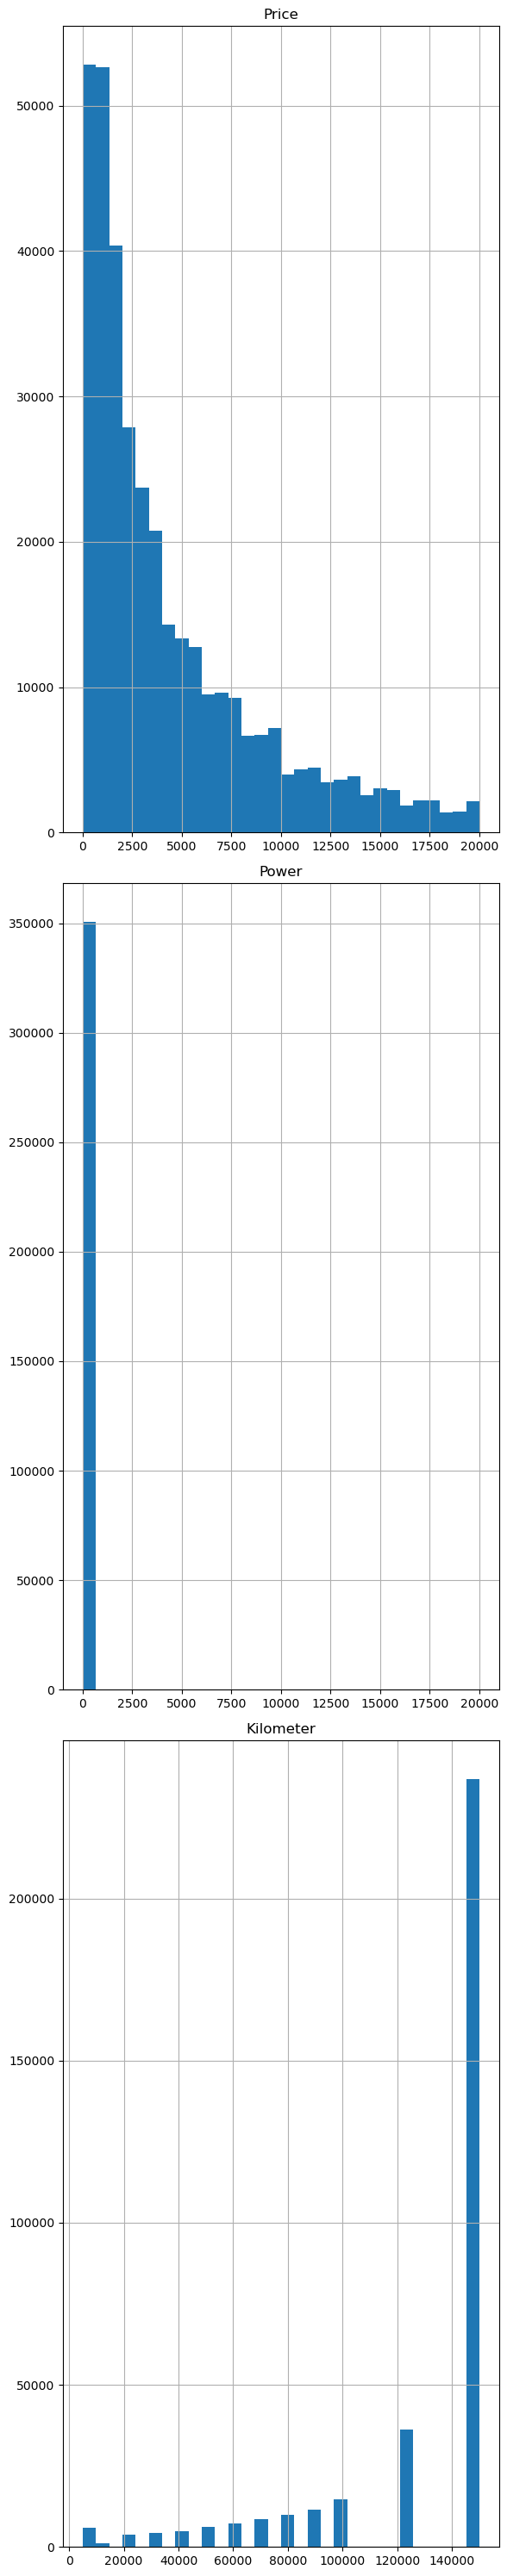

In [17]:
numeric_columns = df1.select_dtypes(int).columns
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(6, 30))
for i, ax in enumerate(axes):
    df1[numeric_columns[i]].hist(bins=30, ax=ax)
    ax.set_title(numeric_columns[i])
plt.tight_layout()
plt.show()




<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Отличные графики и оформлены хорошо - не забыто добавление заголовков и благодаря использованию seaborn легенды и надписи по осям присутствуют.

    
    
Отдельная плюс за использование  subplots, но может стоит с его помощью разместить твои графики в несколько столбцов для компактности
    
    

<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Признаки с датами ниже были удалены в пункте 2.1.</font>
</div>

#### <s>RegistrationYear</s>

<s>Признак **RegistrationYear** явно содержит аномальные значения. Рассмотрим его подробнее объекты с годами регистрации больше **2016** и меньше **1900**.</s>

In [18]:
#reg_year_mask = (df1["RegistrationYear"] > 2016) | (df1["RegistrationYear"] < 1900)
#display(df1[reg_year_mask].head(5))
#print(f'Доля объектов с ошибкой в годе регистрации: {reg_year_mask.sum() / len(df1):.3%}')

<s>Налицо явная ошибка в исходных данных: год не может быть больше 2016. Скорее всего, она произошла при вводе, копировании или обработке. Но так как процент объектов с ошибкой в годе регистрации значителен (4.108%), но придётся удалить эти объекты.</s>

In [19]:
#df1 = df1.drop(df1[reg_year_mask].index)

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:





Стоит обратить внимание что верхняя граница — 2016 год - год выгрузки базы

<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Как-то я этот факт пропустил. Спасибо.<br>Выше исправил.</font>
</div>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:



Возможно строчки с годом больше 2016 содержали некорректные данные, теперь получается эти строки остались на месте. Стоило сначала удалить строчки с годом больше 2016 а потом год как неинформативный - затрудняюсь сказать, в принципе можно было вывести эти строки, и посмотреть насколько данные в другие столбцах выглядят корректно. Вот такой есть момент


#### <s>RegistrationMonth</s>

<s>Признак **RegistrationMonth** явно содержит нули. Рассмотрим его подробнее.</s>

In [20]:
#reg_month_mask = (df1['RegistrationMonth'] == 0)
#df1[reg_month_mask].shape[0]

In [21]:
#print(f'Доля объектов с ошибкой в месяце регистрации: {reg_month_mask.sum() / len(df1):.1%}')

<s>Налицо явная ошибка в исходных данных. Скорее всего, пользователи не ввели месяц. Процент объектов с нулевым месяцем  достаточно велик(9.7%) - удалять его нельзя. Оставим, как есть, но в дальнейшем надо разобраться, откуда берётся это значение.</s>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:



Действительно 0 месяцев вряд ли указывает что данные в других столбцах некорректные, удалять не стоит. 
    
    
    Оставим, как есть, но в дальнейшем надо разобраться, откуда берётся это значение.

    
Вряд ли этот столбец вообще несёт какую-то полезную информацию для прогноза таргета, поэтому можно проигнорировать   

<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Я понял. Спасибо.</font>
</div>

#### Power

Количество объектов со слишком большой мощностью двигателя: 0.08%


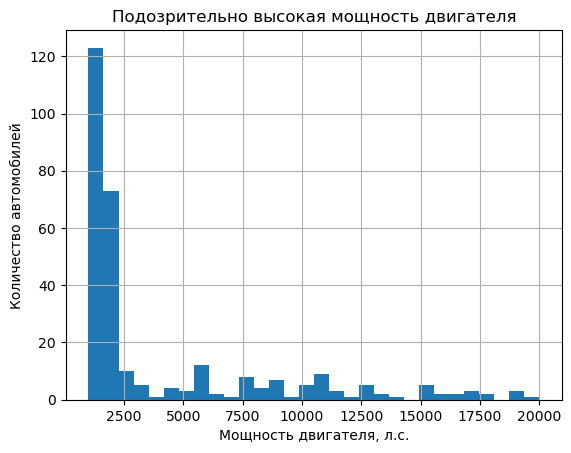

In [22]:
reg_power_mask = (df1['Power'] > 1000)
print(f'Количество объектов со слишком большой мощностью двигателя: {reg_power_mask.sum() / len(df1):.2%}')
df1[reg_power_mask]['Power'].hist(bins=30)
plt.title('Подозрительно высокая мощность двигателя')
plt.xlabel('Мощность двигателя, л.с.')
plt.ylabel('Количество автомобилей');

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:



А вот тут стоит добавить подписи по осям и название графика


<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Добавил.</font>
</div>

Вероятно, аномалии в мощности двигателя связаны с ошибкой в конвертации или вводе данных. Мощности у некоторых автомобилей увеличены в 10-100 раз. Но этих объектов очень мало (0.08%), поэтому просто удалим их.

In [23]:
df1 = df1.drop(df1[reg_power_mask].index)

В данных много объектов с мощностью равной нулю. Пользователи, вероятно, забыли заполнить это поле и по умолчанию оно стало нулём. Его можно заполнить так же, как пропущенные значения.

In [24]:
reg_power0_mask = (df1['Power'] == 0)
print(f'Количество объектов с нулевой мощностью двигателя: {reg_power0_mask.sum() / len(df1):.2%}')
df1[reg_power0_mask].head(3)

Количество объектов с нулевой мощностью двигателя: 11.07%


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,manual,0,golf,150000,petrol,volkswagen,no
15,450,small,manual,0,ka,5000,petrol,ford,no
32,245,sedan,manual,0,golf,150000,petrol,volkswagen,no


Подберём для них значение мощности по соответствующим значениям других признаков.

In [25]:
power_group = df1.groupby(['Brand', 'Model', 'VehicleType', 'FuelType'])['Power'].mean()

# функция возвращает среднее значение мощности для данного типа объектов
# проверка на тип и модель автомобиля + тип топлива
def get_power(row):
    if row['Model'] in power_group[row['Brand']]:
        if row['VehicleType'] in power_group[row['Brand']][row['Model']]:
            if row['FuelType'] in power_group[row['Brand']][row['Model']][row['VehicleType']]:
                return power_group[row['Brand']][row['Model']][row['VehicleType']][row['FuelType']]
            else:
                return power_group[row['Brand']][row['Model']][row['VehicleType']].mean()
        else:
            return power_group[row['Brand']][row['Model']].mean()
    else:
        return power_group[row['Brand']].mean()

df1.loc[reg_power0_mask, 'Power'] = df1[reg_power0_mask].apply(get_power, axis=1).astype(int)

Удалим оставшиеся необработанными значения.

In [26]:
df1 = df1.drop(df1[df1['Power'] == 0].index)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:


проще было сразу удалить, так как все равно это на наш прогноз никак не повлияет, но если хочешь попробовать востановить где оказались нули - почему нет

<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Да, порой хочется заполнить всё, что более-менее понятно, как и зачем заполнять))).</font>
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Почему бы не попрактиковаться в заполнение,  Тем более у тебя уже есть готовая схема функции со сложной логикой заполнения по средней в группировке


#### Price

В наборе данных присутствуют автомобили с нулевой ценой. Рассмотрим этот случай подробнее.

In [27]:
reg_price0_mask = (df1['Price'] == 0)
print(f'Количество объектов со нулевой ценой двигателя: {reg_price0_mask.sum() / len(df1):.2%}')
df1[reg_price0_mask].head(3)

Количество объектов со нулевой ценой двигателя: 2.91%


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,manual,50,other,40000,petrol,volkswagen,no
40,0,small,manual,56,corsa,150000,petrol,opel,no
111,0,sedan,manual,92,golf,5000,petrol,volkswagen,no


Так как количество таких объектов невелико (2.82%), а обучать на нулевых значениях не имеет смысла, то просто удалим из набора эти объекты, чтобы не смещать прогноз.

In [28]:
df1 = df1[df1['Price'] != 0]

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:


Кажется проще было так
    
    df = df[df['price'] != 0]


<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Согласен. Спасибо.</font>
</div>

Рассмотрим структуру цен на гистограмме.

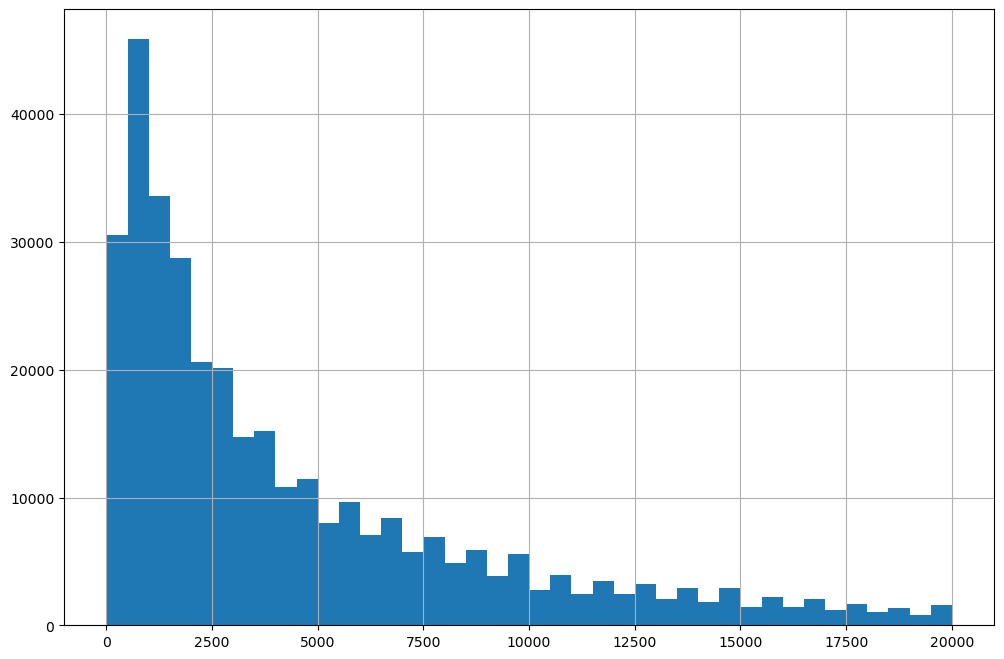

In [29]:
df1['Price'].hist(bins=40, figsize=(12, 8));

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет 🤔:


- Если хочешь убрать AxesSub.  то ставь в конце `;` или пропиши plt.show()


<s>Введём новый бинарный признак: **is_expensive** - высокая ли цена у автомобиля. Критерием будет цена выше 10000 евро.</s>

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка:


Price это наш таргет, то что нам нужно предсказать, нечто неизвестное, а ты на основе него создаешь признак. Это называется подглядыванием


<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Да, это я увлёкся слишком! Спасибо. <br> Убрал из кода.</font>
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



👍




</div>


In [30]:
#df1['is_expensive'] = df1['Price'].apply(lambda x: int(x >= 10000))

In [31]:
#df1.corr(numeric_only=True)['is_expensive']

### Выводы 1

In [32]:
print('Результаты предобработки данных:')
print(f'Размер выборки: {df1.shape}')
print(f'Удалено объектов: {len(df) - len(df1)} ({(len(df) - len(df1)) / len(df):.2%})')
print(f'Количество пропусков в данных: {df1.isna().sum().sum()}')

Результаты предобработки данных:
Размер выборки: (340259, 9)
Удалено объектов: 14110 (3.98%)
Количество пропусков в данных: 0


Данные имеют не самое лучшее качество. Особенно информация о ремонте автомобилей, которая может сильно влиять на цену. Возможно, следует улучшить сбор данных от пользователей с целью уменьшения количества пропусков и некорректно введённой информации.

## Подготовка выборок для обучения

<s>Так как модель автомобиля зависит от бренда, то лучше объединить признаки **Brand** и **Model** в один общий признак.</s>

In [33]:
#df1['Brand_Model'] = df1['Brand'] + '_' + df1['Model']
#df1 = df1.drop(['Brand', 'Model'], axis=1)

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка:



Наверное только Метрика, могла бы рассудить насколько полезно такое действие. Пока я вижу что вместо двух столбцов с мЕньшим числом уникальных значений,  ты получил один столбец в бОльшем числом уникальных значений. 

Но вот на что точно стоит обратить внимание в этом ракурсе - это на 'petrol' и 'gasoline', ведь это   название одного и того же в разных странах    

<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Согласен. Спасибо.<br> Убрал из кода. Добавил коррекцию топлива ниже.</font>
</div>

Так как "petrol" и "gasoline" - это по своей сути одно и то же, то приведём это к одному значению.

In [34]:
df1.loc[df1['FuelType'] == 'petrol', 'FuelType'] = 'gasoline'

In [35]:
df1['FuelType'].unique()

array(['gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

### Разделение выборки

Разделим выборку на три части: обучающая, тестовая, валидационная - 3:1:1.

In [36]:
features = df1.drop('Price', axis=1)
target = df1['Price']

X_train_valid, X_test, y_train_valid, y_test = train_test_split(features, target, 
                                                                test_size=0.2, 
                                                                shuffle=True, 
                                                                random_state=RSTATE)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, 
                                                      test_size=0.25, 
                                                      shuffle=True, 
                                                      random_state=RSTATE)
print(f'Train features: {X_train.shape}')
print(f'Valid features: {X_valid.shape}')
print(f'Test  features: {X_test.shape}')
print(f'Train target:   {y_train.shape}')
print(f'Valid  target:  {y_valid.shape}')
print(f'Test  target:   {y_test.shape}')

Train features: (204155, 8)
Valid features: (68052, 8)
Test  features: (68052, 8)
Train target:   (204155,)
Valid  target:  (68052,)
Test  target:   (68052,)


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


- random_state на месте



    
- плюс за  проверку
    
    



<div class="alert alert-warning">



Совет: 










- обрати внимание на аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах.  Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым. [Почитать](https://pythonru.com/baza-znanij/sklearn-train-test-split) можно тут




### Подготовка признаков

#### Категориальные признаки

<s>Закодируем категориальные признаки методом OneHotEncoder.</s>

In [37]:
# код ревьюера

# cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'is_expensive']
# cat_features_ohe = list(map(lambda x: x + '_ohe', cat_features))

# ohe_encoder = OneHotEncoder(drop='first', sparse=False)
# X_train[ohe_encoder.get_feature_names()] = ohe_encoder.fit_transform(X_train[cat_features])
# X_valid[ohe_encoder.get_feature_names()] = ohe_encoder.transform(X_valid[cat_features])
# X_test[ohe_encoder.get_feature_names()]  = ohe_encoder.transform(X_test[cat_features])

# X_train = X_train.drop(cat_features, axis=1)
# X_valid = X_valid.drop(cat_features, axis=1)
# X_test = X_test.drop(cat_features, axis=1)

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:


- Тут опять вылетает ошибка исполнения кода, пришлось подправить на handle_unknown='error' и 'get_feature_names'. Всё-таки стоит ориентироваться на версию которая у нас в тренажёре
    
    
- А во вторых данный способ кодирования отлично подошёл бы для линейных моделей (можешь обьяснить почему? почему для линейных не годится OrdinalEncoder, в отличие от деревянных), но ты их не использовал.  
    
    
Для древесных моделей  не стоит использовать `OneHotEncoder()` или его упрощенный аналог `get_dummies()`, эта техника кодирования увеличивает количество признаков, в результате чего модели сложнее создавать разделяющие правила, поэтому время работы и расчётные характеристики моделей сильно страдают на больших наборах данных. 
    
    
Вместо этого мы можем использовать
    
- `OrdinalEncoder()`: Этот метод кодирования категориальных признаков назначает уникальные целочисленные значения каждой категории. Это позволяет модели работать с категориальными данными более эффективно при создании разделяющих правил.

- Внутренние кодировщики: Некоторые бустинговые библиотеки, такие как CatBoost и LightGBM, имеют встроенные методы работы с категориальными признаками. Например, в CatBoost можно использовать параметр `cat_features`, чтобы указать, какие признаки являются категориальными. В LightGBM можно привести категориальные признаки к типу category, и модель будет автоматически обрабатывать их как категориальные.  Тут можно посомтреть где то с 25 минуты о [работе с категориальными признаками в catboost](https://www.youtube.com/watch?v=UYDwhuyWYSo&t=1578s&ab_channel=ComputerScienceCenter) 

<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Спасибо. Было непросто решить, что делать с разными типами признаков.
        <br> Убрал из кода. Добавил категориальные признаки в ординальное кодирование.</font>
</div>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:

    
    
Я бы так написал логику принятия решений работу с категориальными (и почему):    
    

Если мы используем CatBoost или LightGBM, ничего с категориальными делать не нужно, в  моделях указываешь какие признаки у нас категориальные, и модели сами знают как с ними работать. Вопрос снят
    
    
Если не CatBoost или LightGBM, а например линейная модель...Кажется проще сделать    OrdinalEncoder, он позволит текст в столбце "топливо" поменять на цифры (допустим бензин станет 2 а электричество - 1, а гибрид 3), но проблема в том что для линейной модели окажется что бензин больше электричества, а гибрид больше бензина, и он будет стараться построить линию исходя из этих неверных предположений (ведь никакой структуры больше-меньше на самом деле нет). А если использовать OneHotEncoder, то такой проблемы нет. 
    
    
    
А вот если у нас какой-нибудь Случайный лес или дерево решений, то даже если сделать OrdinalEncoder, то в силу того что модели на основе деревьев решений, делают сплиты (в отличии от линейных, которые строят линию), то не страшно что "бензин больше электричества". Он всё равно сможет построить нужный сплит, это не линейные модели, они могет. Поэтому для случайного леса или дерева решени можно использовать и OrdinalEncoder и OneHotEncoder (первое предпочтительней,  если OneHotEncoder создает уж очень много признаков, а деревянные модели известны тем что они очень долго обучаются)

#### Ординальные признаки

Признаки ниже было решено кодироваль ординально, чтобы не "раздувать" в ширину набор данных для обучения.

In [38]:
ord_features = ['Brand', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Kilometer']
ord_features_ord = list(map(lambda x: x + '_ord', ord_features))

# определим категории для ординального кодирования
ord_cats = []
for feat in ord_features:
    if feat == 'Kilometer':
        ord_cats.append(np.arange(0, df1[feat].max() + 1, df1[feat].min()))
    else:
        ord_cats.append(df1[feat].unique())

# кодирование ординальных признаков
ord_encode = OrdinalEncoder(categories=ord_cats)
#ord_encode = OrdinalEncoder()
X_train[ord_features_ord] = ord_encode.fit_transform(X_train[ord_features])
X_valid[ord_features_ord] = ord_encode.transform(X_valid[ord_features])
X_test[ord_features_ord]  = ord_encode.transform(X_test[ord_features])

X_train = X_train.drop(ord_features, axis=1)
X_valid = X_valid.drop(ord_features, axis=1)
X_test  = X_test.drop(ord_features, axis=1)

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка:



'RegistrationYear', 'RegistrationMonth' и вообще все даты  - кажется эти данные так же "полезны" как число фотографии


<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Согласен. Спасибо.<br> Удалил эти признаки в пункте 2.1.</font>
</div>

In [39]:
print(f'Train features: {X_train.shape}')
print(f'Valid features: {X_valid.shape}')
print(f'Test features:  {X_test.shape}')

Train features: (204155, 8)
Valid features: (68052, 8)
Test features:  (68052, 8)


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:



- Предобработка признаков завершена. Ты поработал с категориальными данными, но ничего не сделал для количественных (для них своя техника работы - шкалирование или нормализация), не ставлю красный, потому что ты не использовал модели для которых это было бы принципиально важно
    
- Кстати есть красивый вариант работы с разными типами данных с использованием pipeline и ColumnTransformers:
1. https://medium.com/mlearning-ai/neat-data-preprocessing-with-pipeline-and-columntransformer-2a0468865b6b
2. https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156
 

<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Да, я не обрабатывал количественные признаки, исходя из выбранных моделей.<br> Спасибо за ссылки. Обязательно изучу.</font>
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



здорово что это понимаешь




</div>


## Обучение моделей

Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

### Простые модели

Сначала обучим для сравнения простые модели (решающее дерево и случайный лес) на кросс-валидации и подберём параметры.

In [40]:
# объединённая выборка для кросс-валидации
X_cv = pd.concat([X_train, X_valid])
y_cv = pd.concat([y_train, y_valid])

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



Действительно, если ты используешь GridSearchCV валидационный выборку можно не создавать


In [41]:
dtree_params = {'max_depth': range(1, 21)}

dtree_cv = GridSearchCV(estimator=DecisionTreeRegressor(random_state=RSTATE),
                        param_grid=dtree_params,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        cv=3
                       )

dtree_cv.fit(X_cv, y_cv)

print(f'Решающее дерево: параметры = {dtree_cv.best_params_} RMSE = {-dtree_cv.best_score_}')

Решающее дерево: параметры = {'max_depth': 17} RMSE = 2525.60279792983


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Чтобы лучше понять процесс моделирования стоит использовать циклы прописанные вручную, если ты уверен в своих знаниях то почему бы не попробовать оболочку GS    
    

- не забыт random_state




- scoring = 'neg_root_mean_squared_error'    
    

    
    
<div class="alert alert-warning">

Совет:







Молодец что используешь GridSearch, но еще лучше использовать связку [GridSearchCV + pipeline](https://towardsdatascience.com/an-introduction-to-building-pipelines-and-using-grid-searches-in-scikit-learn-92ea72f9b5b7)       (Скорее всего открывается с VPN) Особенно это важно если есть предварительный предобработка данных (заполнение пропусков средней, Scaler, перебалансировка, TFIDF итп итд). Без использования pipeline произойдёт утечка данных, а также Метрика на кроссвалидации и подбор гиперпараметров будет не корректным
    
    
    

    
Объясню подробнее - когда мы используем вручную прописанный цикл для поиска гиперпарамтеров, и разбиваем на три датасета, то мы же делаем так (пусть тут будет предобработка  StandardScaler):
    


    scaler = StandardScaler()
    scaler.fit(train_feat[numeric])


    feat_train[numeric] = scaler.transform(feat_train[numeric])
    feat_test[numeric] = scaler.transform(feat_test[numeric])
    feat_valid[numeric] = scaler.transform(feat_valid[numeric])
    
    
    
То есть мы делаем   .fit на train, а на valid и test делаем   .transform, то есть когда мы обучаем наш StandardScaler,  мы используем только тренировочный датасет, а затем "распростроняем" выученное шкалирование на test/valid.  Нет подглядывания:   Мы не используем информацию из тестового и валидационного датасета, для того чтобы обучить StandardScaler(). В этом и смысл моделирования - мы как будто бы знаем только train, а тестового для нас как бы не существует.  Если мы при шкалировании начинаем использовать информацию из теста мы поступаем нечестно. 

    
    
А когда используем GridSearch
    
    
Вот твой код (условно)    
    
    scaler = StandardScaler()
    scaler.fit(train_feat)
    feat_train = scaler.transform(feat_train)    
    
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters)
    clf.fit(feat_train, target)
    
    
    
Обрати внимание - ты подал  feat_train, из  которого   GridSearchCV сам создаст valid и train и построит циклы. И вот тут оказывается что валидационный датасет у нас с подглядыванием, потому что на всем feat_train был сделан fit.  Вот в чём заключается подглядывание.  И раз GS делает валидационные внутри себя, спрашивается как добраться до нее и избежать подглядывания в будущее? Казалось бы никак, но нет! Pipeline! ) 
    
    
  
    
И вот как надо сделать pipeline чтобы не было утечки данных при шкалировании.  Как видишь кода немного 
    
    pipe = Pipeline([
            ('scale', StandardScaler(random_state = 42)),
            ('clf', SVC(kernel = 'linear', C = 1))])

    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

    clf = GridSearchCV(pipe, parameters)
    clf.fit(feat_train, target)
    
    
И теперь    feat_train будет разбит на train и valid, но .fit будет на train, а на valid будет .transform. Такй вот хитрый pipeline - он суёт свои ручки внутрь GS и делай так чтобы не было утечки данных.
    
        
    


<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Спасибо большое за разбор. А то эта тема с утечками и пайплайнами была для меня смутной.<br> Изучу и буду использовать по-новому.</font>
</div>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:



Тут я привёл пример утечки данных если не использовать pipeline. А ведь может быть проблема с неадекватной метрикой на .best_score_ .  Например, ты сбалансировал X_cv, использовал GridSearchCV, а потом с помощью .best_score_ посмотрел метрику f1. Так вот она у тебя будет завышенной, потому что f1 получается гораздо выше на сбалансированных данных. А если использовать pipeline, то метрика на кросс валидации будет адекватный и когда ты будешь проводить финальное тестирование на несбалансированной тектосвой, то метрики не будут сильно отличаться.  


In [42]:
rforest_params = {'max_depth': [5, 10, 20],
                  'n_estimators': [100, 200]
                 }

rforest_cv = GridSearchCV(estimator=RandomForestRegressor(random_state=RSTATE, n_jobs=-1),
                          param_grid=rforest_params,
                          scoring='neg_root_mean_squared_error',
                          n_jobs=-1,
                          cv=3
                         )

rforest_cv.fit(X_cv, y_cv)

print(f'Случайный лес: параметры = {rforest_cv.best_params_} RMSE = {-rforest_cv.best_score_}')

Случайный лес: параметры = {'max_depth': 20, 'n_estimators': 200} RMSE = 2263.940008559657


### LightGBM

Теперь обучим модель LightGBM на кросс-валидации с подбором параметров.

In [43]:
lgb_params = {'n_estimators': [100, 200],
              'max_depth': [5, 10, 20],
              'learning_rate': np.arange(0.1, 0.51, 0.1)
             }

lgb_cv = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=RSTATE, n_jobs=-1),
                      param_grid=lgb_params,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=-1,
                      cv=3
                     )

lgb_cv.fit(X_cv, y_cv)
        
print(f'LightGBM: параметры = {lgb_cv.best_params_} RMSE = {-lgb_cv.best_score_}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 272207, number of used features: 8
[LightGBM] [Info] Start training from score 4546.074271
LightGBM: параметры = {'learning_rate': 0.5, 'max_depth': 20, 'n_estimators': 200} RMSE = 2255.103447743386


## Анализ моделей

Сравним выбранные модели с лучшими найденными параметрами на соответствие критериям заказчика.

In [44]:
dtree_model = DecisionTreeRegressor(max_depth=dtree_cv.best_params_['max_depth'])
rforest_model = RandomForestRegressor(max_depth=rforest_cv.best_params_['max_depth'],
                                      n_estimators=rforest_cv.best_params_['n_estimators'],
                                      n_jobs=-1
                                     )
lgb_model = lgb.LGBMRegressor(n_estimators=lgb_cv.best_params_['n_estimators'], 
                              max_depth=lgb_cv.best_params_['max_depth'],
                              num_leaves=41,
                              learning_rate=lgb_cv.best_params_['learning_rate'],
                              random_state=RSTATE, n_jobs=-1
                             )

### Время обучения

In [45]:
dtree_train_time = %timeit -n1 -r1 -o dtree_model.fit(X_train, y_train)
rforest_train_time = %timeit -n1 -r1 -o rforest_model.fit(X_train, y_train)
lgb_train_time = %timeit -n1 -r1 -o lgb_model.fit(X_train, y_train)

451 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
22.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 204155, number of used features: 8
[LightGBM] [Info] Start training from score 4551.733918
638 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [46]:
print(f'Решающее дерево: время обучения = {round(dtree_train_time.best, 2)} секунд')
print(f'Случайный лес:   время обучения = {round(rforest_train_time.best, 2)} секунд')
print(f'LightGBM:        время обучения = {round(lgb_train_time.best, 2)} секунд')

Решающее дерево: время обучения = 0.45 секунд
Случайный лес:   время обучения = 22.52 секунд
LightGBM:        время обучения = 0.64 секунд


### Время предсказания

In [47]:
dtree_predict_time = %timeit -n1 -r1 -o dtree_model.predict(X_valid)
rforest_predict_time = %timeit -n1 -r1 -o rforest_model.predict(X_valid)
lgb_predict_time = %timeit -n1 -r1 -o lgb_model.predict(X_valid)

27.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
106 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [48]:
print(f'Решающее дерево: время предсказания = {round(dtree_predict_time.best, 2)} секунд')
print(f'Случайный лес:   время предсказания = {round(rforest_predict_time.best, 2)} секунд')
print(f'LightGBM:        время предсказания = {round(lgb_predict_time.best, 2)} секунд')

Решающее дерево: время предсказания = 0.03 секунд
Случайный лес:   время предсказания = 1.05 секунд
LightGBM:        время предсказания = 0.11 секунд


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



Здорово что обратил внимание на время прогнозирования и обучения моделей, это важный критерий при выборе модели особенно в продакшн

</div>


### Качество моделей

С параметрами по умолчанию на кросс-валидации лучший результат показала модель LightGBM.

In [49]:
print(f'Решающее дерево: RMSE = {mean_squared_error(y_valid, dtree_model.predict(X_valid), squared=False)}')
print(f'Случайный лес:   RMSE = {mean_squared_error(y_valid, rforest_model.predict(X_valid), squared=False)}')
print(f'LightGBM:        RMSE = {mean_squared_error(y_valid, lgb_model.predict(X_valid), squared=False)}')

Решающее дерево: RMSE = 2493.555169513658
Случайный лес:   RMSE = 2243.411910561895
LightGBM:        RMSE = 2231.6026119281814


### Выводы 2

Анализ моделей показал, что качество моделей LightGBM чуть выше чем у RandomForest, однако, RandomForest обучается и прогнозирует значительно медленнее. Качество же DecisionTree заметно ниже, чем у этих двух моделей. Исходя из требований заказчика для тестирования выбираем модель **LightGBM**.

## Проверка лучшей модели

Проверим лучшую модель на тестовой выборке и оценим её качество.

In [50]:
print(f'Лучшая модель: RMSE = {mean_squared_error(y_test, lgb_model.predict(X_test), squared=False)}')

Лучшая модель: RMSE = 2219.060178459619


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех: 

- Все верно, логика моделирования не нарушена, тут тестируем только лучшую модель отобранную на валидации, или парочку лучших, если на валидации результаты близки




- Если студент получил на тесте RMSE ниже 2500, это считается приемлемым результатом.



<div class="alert alert-warning">


Совет: 


Можешь посмотреть какие признаки  является наиболее важными с точки зрения модели (feature_importances_)

А ещё есть такая интересная библиотека shap — позволяет детально изучить работу модели, в том числе оценить важность признаков, при этом не привязана к работе конкретного алгортима прогнозирования. Вот статья с описанием ее работы — https://habr.com/ru/articles/428213/ и детальный разбор графиков - https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

<div style="background: #e1cfff; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='black'>🦋<u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='black'>Спасибо за советы. Изучу.</font>
</div>

Оценим важность признаков в модели.

In [51]:
pd.Series(data=lgb_model.feature_importances_, index=lgb_model.feature_name_).sort_values(ascending=False)

Power              2817
Model_ord          1734
Kilometer_ord      1154
Brand_ord          1152
VehicleType_ord     753
Gearbox_ord         237
Repaired_ord         90
FuelType_ord         63
dtype: int32

Оценим "вменяемость" модели, сравнив её dummy-моделью (среднее значение).

In [52]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_test, y_test)
print(f'Dummy-модель: RMSE = {mean_squared_error(y_test, dummy_model.predict(X_test), squared=False)}')

Dummy-модель: RMSE = 4501.023069020895


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



Здорово что тспользован DummyRegressor для проверки модели на адекват




</div>


## Выводы

1. Данные оказались не самого высокого качества: у части автомобилей отсутствуют значимые данные (мощность, ремонт), присутствует большое число аномалий. Всё это связано, вероятно, со способом ввода и обработки данных. Стоит ввести проверку вводимой информации для улучшения качества исходных данных. Часть пропущенных значений и аномалий была обработана, чтобы и сохранить данные и не ухудшить качество моделей.
2. Данные были разделены и признаки были закодированы.
3. Выбраны три модели: DecisionTree, RandomForest и LightGBM. Методом кросс-валидации были найдены лучшие параметры для них.
4. Модели были обучены, проведено их сравнение на соответствие их требованиям заказчика (время обучения, время прогнозирования, качество). Лучшая модель - **LightGBM**.
5. В лучшей модели наиболее важными признаками стали: мощность двигателя, бренд и модель автомобиля, пробег.


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>


Кирилл, у тебя старательно выполненная работа, все четко, осмысленно. Выводы присутствуют, они четкие и подробные, графики оформлены аккуратно. Здорово что для подбора гиперпараметров используешь GS, оставил советы по использованию его в связке с pipeline




Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить)
    


Обязательное к исправлению:



- если после удаления пропусков мы уменьшаем наш нашу выборку более чем на 10%, есть повод задуматься необходимости такого удаления

  
- я бы обратил внимание что не все неинформативные признаки удалены


- стоит обратить внимание что верхняя граница — 2016 год - год выгрузки базы



- Price это наш таргет, мы не можем использовать информацию из него для создания признаков

    
- 'petrol' и 'gasoline' то   название одного и того же в разных странах        
    
    
    
- для древесных моделей не стоит использовать OneHotEncoder()
    
    
    
- есть ошибки исполнения кода, некоторые связаны с разными версиями используемых библиотек. все же стоит ориентироваться на версии используемые в тренажере   
    
    
Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 


</div>



<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Спасибо за работу!    

    
Красное исправлено Надеюсь мои советы и вопросики были полезны и в копилочку знаний упало что то новое, а проект стал лучше, и симпатичней.


  
Отличная работа Кирилл. Желаю успехов в дальнейшей учебе!

